# get financial data

[yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/#installation)を使う。

## installation

```bash
$ pip install yahoo_fin
```

## memo


- get [summary](https://finance.yahoo.com/quote/GOOGL?p=GOOGL)
    - `si.get_quote_table(ticker)`
```
1y Target Est
52 Week Range
Ask
Avg. Volume
Beta (5Y Monthly)
Bid
Day's Range
EPS (TTM)
Earnings Date
Ex-Dividend Date
Forward Dividend & Yield
Market Cap
Open
PE Ratio (TTM)
Previous Close
Quote Price
Volume
```
- get [statistics](https://finance.yahoo.com/quote/GOOGL/key-statistics?p=GOOGL)
    - `si.get_stats_valuation(ticker)`
```
Market Cap (intraday) 5
Enterprise Value 3
Trailing P/E
Forward P/E 1
PEG Ratio (5 yr expected) 1
Price/Sales (ttm)
Price/Book (mrq)
Enterprise Value/Revenue 3
Enterprise Value/EBITDA 7
```
上記末尾の数字は，Yahoo Financeのサイトの各項目の注釈番号
- get [analytics](https://finance.yahoo.com/quote/GOOGL/analysis?p=GOOGL)
    - `si.get_analysts_info(ticker)`
```
Earnings Estimate
Revenue Estimate
Earnings History
EPS Trend
EPS Revisions
Growth Estimates
```

- get earnings history
    - `si.get_earnings_history(ticker)`
    - EPS actual/estimate


## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)

In [390]:
ticker="SQ"
#df=si.get_quote_table(ticker)
#df=si.get_stats_valuation(ticker)
#dic_tmp=si.get_analysts_info(ticker)
#dic_earnings=si.get_earnings_history(ticker)
#display(df)

In [496]:
import yahoo_fin.stock_info as si
import pandas as pda
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

    
def defaultPlotting(): 
    sns.set(rc={'figure.figsize':(8,5),
        "font.size":20,
                "axes.titlesize":20,
                "axes.labelsize":20,
                "font.size":20,
                "legend.fontsize":15
               },style="white")
    sns.set_style("whitegrid")

    
def today():
    return(datetime.today().strftime('%Y-%m-%d'))
  

In [566]:
# Usage: plot EPS history
# ticker=["SQ"]
# df_earnings=get_earnings_history(ticker)
# plot_eps(df_earnings)

def _get_earnings_history(ticker):
    dct=si.get_earnings_history(ticker)
    df=pd.json_normalize(dct)
    df["startdatetime"]=df["startdatetime"].str.replace(r'T.*$','',regex=True)
#    df=df.set_index("startdatetime").sort_index()
#    df["Ticker"]=ticker
    return(df)

def get_earnings_history(tickers):
    df=_get_earnings_history(tickers[0])

    for ticker in tickers[1:]:
        tmp=_get_earnings_history(ticker)
        df=df.append(tmp)

    return(df)

def _plot_eps(df,ax,last):
    d=df.set_index("startdatetime").sort_index().tail(last)
    sns.lineplot(ax=ax,data=d[["epsactual","epsestimate"]],marker='o')
    ax.set_title(d["ticker"][0])
    ax.tick_params(axis='x', labelrotation = 90)        

    ax.set_xlabel("")
    ax.set_ylabel("EPS")
    
def plot_eps(df,last=1000):
    tickers=df.ticker.unique()
    n_tick=len(tickers)
    if n_tick <= 3:
        max_col=n_tick
    elif n_tick == 4:
        max_col=2
    elif n_tick <= 6:
        max_col=3
    else:
        max_col=3
        
#        max_col=4

    n_tick=len(tickers)
    n_col=min(n_tick,max_col)
    n_row=(n_tick-1)//max_col+1
#    print("ntick: {}, nrow: {}, ncol: {}".format(n_tick, n_row, n_col))

    fig, axes = plt.subplots(n_row, n_col, figsize=(6*n_col,4*n_row))
    fig.suptitle("EPS history within last {} quarters ({})".format(last,today()))

    for i, ticker in enumerate(tickers):
        target = df[df["ticker"]==ticker]
                   
        if n_row == 1:
            if n_tick==1:
                ax=axes
            else:
                ax=axes[i]
        else:
            row=i//n_col
            col=i%n_col
            ax=axes[row,col]

        _plot_eps(target,ax, min(last,len(target)))
        
    fig.tight_layout()
    plt.show()

In [567]:
def _get_ticker_data(ticker):
    data_qt = si.get_quote_table(ticker)
    data_val=si.get_stats_valuation(ticker)

    df_qt=pd.DataFrame.from_dict(data_qt, orient='index')\
        .reset_index()\
        .rename(columns={"index":"info",0:"values"})
    df_val=data_val.rename(columns={0:"info",1:"values"})
    df=pd.concat([df_qt,df_val], ignore_index=True).sort_values(by="info")
    df["Ticker"]=ticker
    return(df)

def get_ticker_data(tickers):

    data = pd.DataFrame(index=[],columns=["Ticker","info","values"])

    for ticker in tickers:
        tmp=_get_ticker_data(ticker)
        data=data.append(tmp, ignore_index=True)
    
    df=data.pivot(index="Ticker",columns="info",values="values")
    
    return(df)

def col_name(df,str):
    return([col for col in df.columns if str in col])


def plot_financials(df,table=False):
    
    PSR=col_name(df,"Price/Sales")
    PBR=col_name(df,"Price/Book")
    PER=col_name(df,"PE Ratio")
    EPS=col_name(df,"EPS")
    Target=col_name(df,"Target")
    Date=col_name(df,"Earnings Date")
    Dividend=col_name(df,"Forward Dividend")
    Price=col_name(df,"Close")

    numeric=Price+Target+PSR+PER+PBR+EPS
    df[numeric]=df[numeric].astype("float")
    
#     df[PSR].plot(kind="hist",bins=20)
#     plt.xlabel("PSR")
#     plt.show()

#    sns.set_theme()
    defaultPlotting()
    ax=sns.histplot(data=df[PSR],bins=20).set_title("PSR histogram ({})".format(today()))
    plt.xlabel("PSR")
    plt.show()
    
    target=numeric+Date
    df_tgt=df[target].sort_values(by=PSR, ascending=False)

    if table==True:
        print(today())
        display(df_tgt)
    else:
        print("{} High PSR stocks (Top 5)".format(today))
        display(df_tgt.head())

    
    return(df_tgt)

In [18]:
# get ticker list
tickers_dow = si.tickers_dow()
# tickers_nasdaq=si.tickers_nasdaq()
# tickers_sp500=si.tickers_sp500()
# tickers_other=si.tickers_other()

## Get data! It takes a while, so please be patient!

In [52]:
# get data of stock indexes
#df_dow=get_tickers_data(tickers=tickers_dow)
#df_nasdaq=get_tickers_data(tickers=tickers_nasdaq)
#df_sp500=get_tickers_data(tickers=tickers_sp500)

## Now, it's time to enjoy!

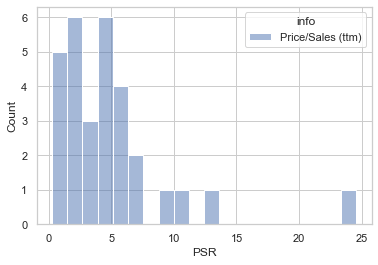

2021-07-12 High PSR stocks (Top 5)


info,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,
V,236.61,268.08,24.57,49.29,14.83,4.84,"Jul 27, 2021"
MSFT,277.42,298.92,13.09,37.88,15.57,7.34,"Jul 27, 2021"
CRM,245.80,278.66,10.15,51.67,5.33,4.74,"Aug 23, 2021 - Aug 27, 2021"
MCD,232.84,258.34,8.96,34.20,NaN,6.89,"Jul 28, 2021"
AAPL,143.24,159.34,7.44,32.62,35.00,4.45,"Jul 28, 2021 - Aug 02, 2021"


In [119]:
# show data
df_dow_final=show_info(df_dow,table=False)

## Get stock info of your favorite
### Tech

In [575]:
fangam=["FB","AAPL","NFLX","GOOG","AMZN","MSFT"]
growth=["ADBE","CRWD","NVDA","TSLA","SQ","DOCU","OKTA","U","ZM","FVRR","ABNB","TTD","TWLO","TWTR","PINS"]
tickers_tech=fangam+growth

### check eps history

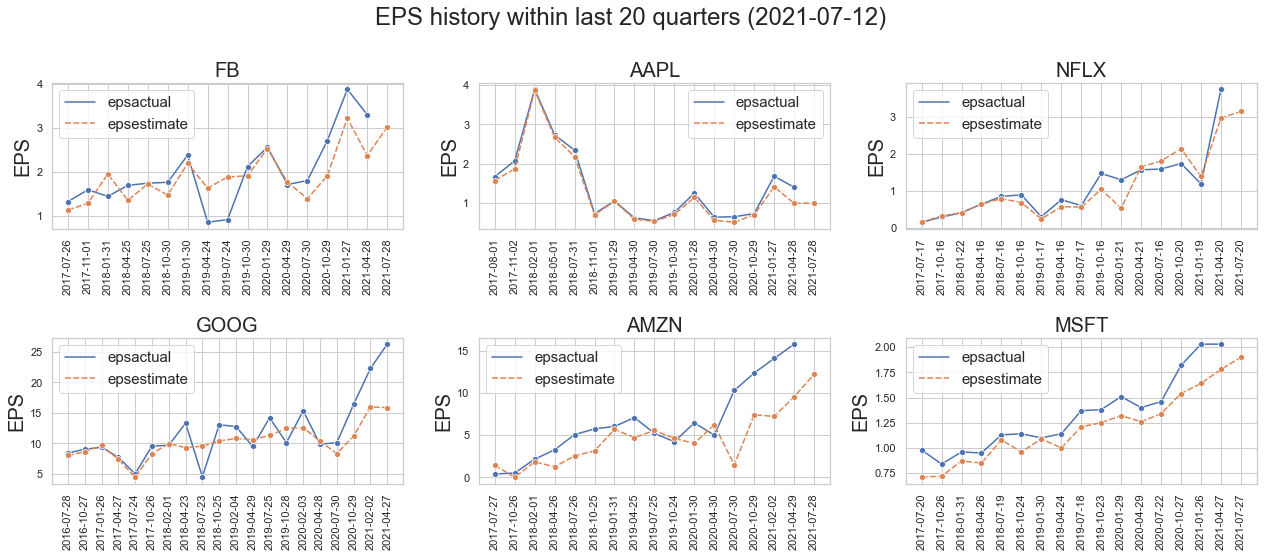

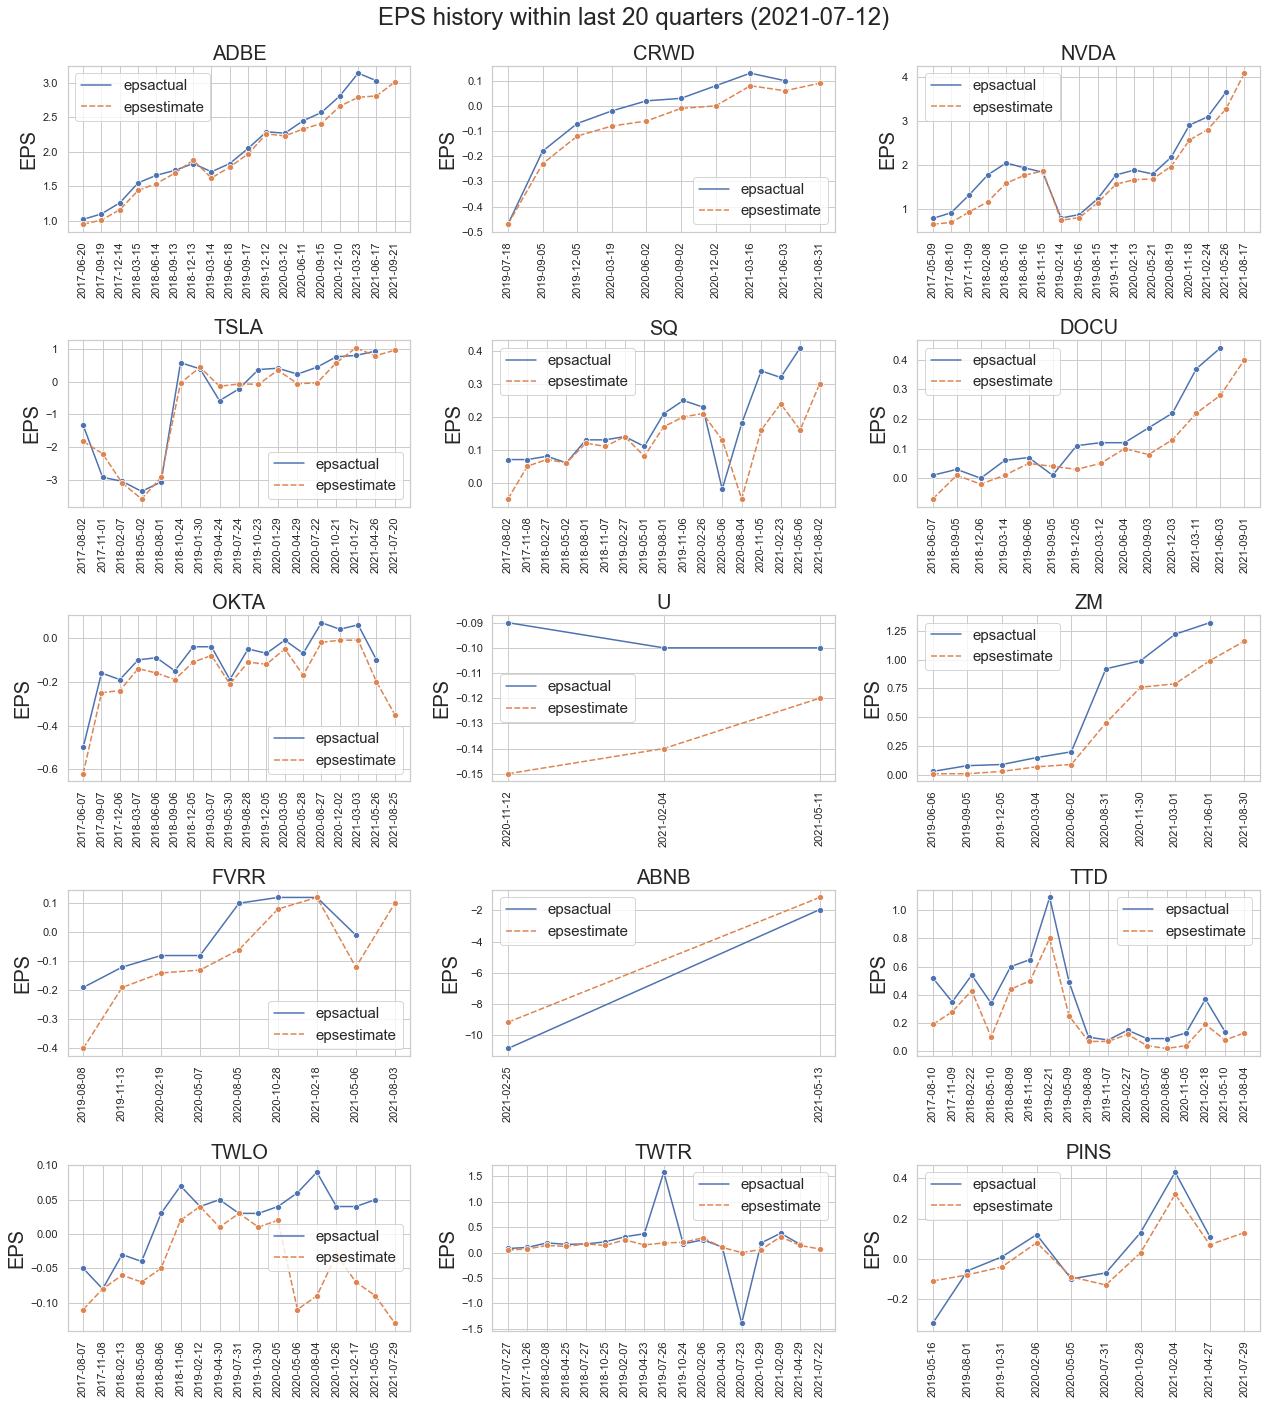

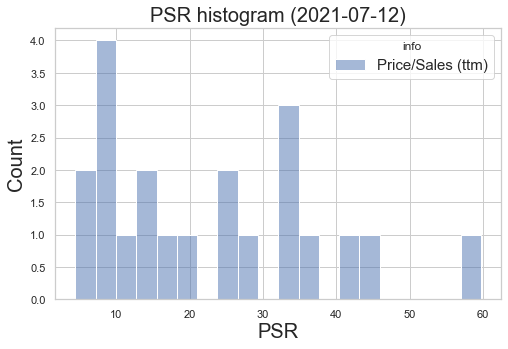

2021-07-12


info,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,
CRWD,263.39,268.08,59.76,NaN,70.29,-0.72,"Aug 31, 2021 - Sep 06, 2021"
FVRR,238.18,258.88,45.55,NaN,49.95,-2.29,"May 06, 2021"
OKTA,251.26,277.00,42.34,NaN,48.90,-2.46,"Aug 25, 2021 - Aug 30, 2021"
U,105.18,123.05,35.43,NaN,NaN,NaN,"Aug 10, 2021"
ZM,386.01,415.48,34.60,132.79,27.05,2.90,"Aug 30, 2021 - Sep 03, 2021"
DOCU,288.74,281.17,34.53,NaN,230.60,-1.08,"Sep 01, 2021 - Sep 06, 2021"
TWLO,384.85,460.79,33.40,NaN,6.54,-3.92,"Aug 02, 2021 - Aug 06, 2021"
ABNB,142.53,172.50,26.99,NaN,NaN,NaN,"May 13, 2021"
NVDA,796.11,757.31,25.95,94.80,26.61,8.46,"Aug 17, 2021 - Aug 23, 2021"


In [578]:
## check eps history

#df_fangam_earnings=get_earnings_history(fangam)
plot_eps(df_fangam_earnings,last=20)

#df_growth_earnings=get_earnings_history(growth)
plot_eps(df_growth_earnings,last=20)

# check PSR and some other financials
#df_tech=get_ticker_data(tickers=tickers_tech)
tmp=plot_financials(df_tech,table=True)

## Health

In [579]:
tickers_health=["ANTM","BMY","BNTX","BIIB","MRNA","PGNY","PFE","VEEV"]

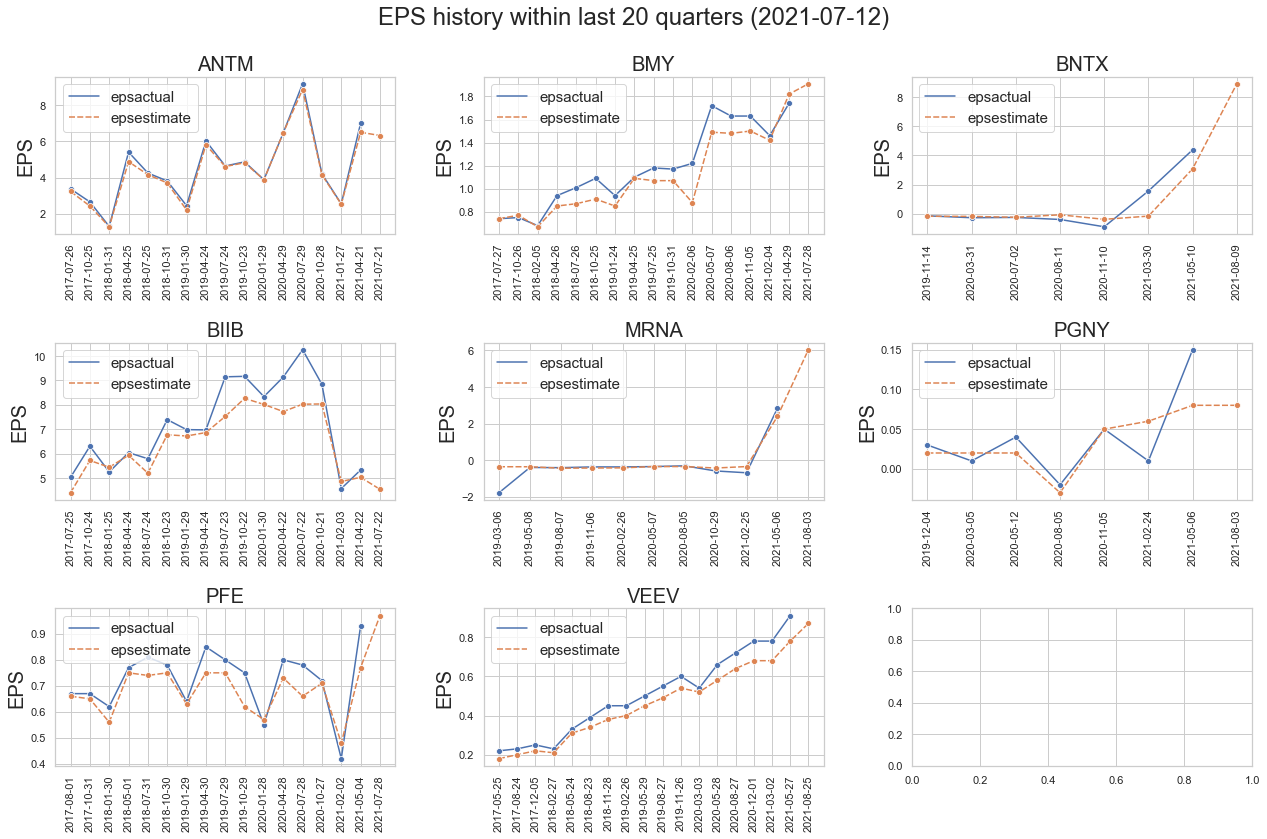

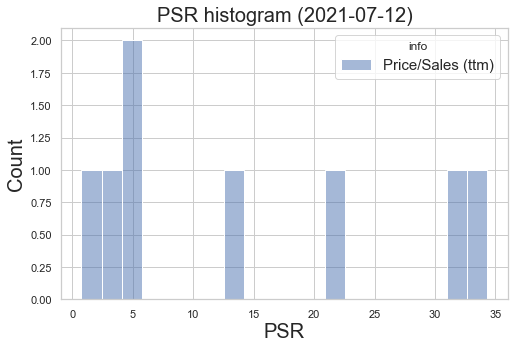

2021-07-12


info,Previous Close,1y Target Est,Price/Sales (ttm),PE Ratio (TTM),Price/Book (mrq),EPS (TTM),Earnings Date
Ticker,,,,,,,
MRNA,232.79,184.92,34.33,156.04,24.32,1.49,"Aug 03, 2021 - Aug 09, 2021"
VEEV,320.40,333.14,31.23,127.04,20.09,2.53,"Aug 25, 2021 - Aug 30, 2021"
BNTX,207.93,196.82,20.98,NaN,NaN,NaN,"Aug 09, 2021"
PGNY,60.05,66.33,13.50,NaN,NaN,-0.99,"Aug 03, 2021 - Aug 09, 2021"
PFE,39.25,43.32,4.78,20.07,3.23,1.97,"Jul 28, 2021"
BIIB,369.05,404.34,4.28,18.57,5.05,19.29,"Jul 22, 2021"
BMY,66.69,75.37,3.50,NaN,3.99,-2.76,"Jul 28, 2021"
ANTM,384.17,427.00,0.76,20.79,2.81,18.69,"Jul 21, 2021"


In [580]:
# EPS history
#df_health_earnings=get_earnings_history(tickers_health)
plot_eps(df_health_earnings,last=20)

# PSR etc...
#health_df=get_ticker_data(tickers=tickers_health)
tmp=plot_financials(health_df,table=True)

## Pyfolioによる情報表示

- [pyfolio](https://github.com/quantopian/pyfolio)

```bash
$ pip install pyfolio
```

## references

- [HOW TO DOWNLOAD FUNDAMENTALS DATA WITH PYTHON](http://theautomatic.net/2020/05/05/how-to-download-fundamentals-data-with-python/)
- [pyfolioを使ってみる](https://qiita.com/mrsn28/items/445553c24861b9930682)

In [213]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/jun/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [214]:
stock_rets = pf.utils.get_symbol_rets('DOCU')
#pf.create_returns_tear_sheet(stock_rets, live_start_date='2015-12-1')
pf.create_returns_tear_sheet(stock_rets)

AttributeError: module 'pandas_datareader.data' has no attribute 'get_data_google'